In [1]:
import pandas as pd
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import InformerForPrediction, InformerConfig
import torch
import torch.nn as nn
import torch.optim as optim
from informer import Informer
from torch.utils.data import DataLoader, TensorDataset
import math
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv(r"C:\Users\Megha\jupyter\Solar-irradiance-code-files\data.csv")

"""
This script reads data from 'data.csv'.
Ensure the folder structure is:
- T-Informer.ipynb
- data.csv
"""

In [3]:
features = ['T2M', 'CLOUD_AMT', 'RH2M', 'HR_SIN', 'HR_COS', 'DAY_SIN', 'DAY_COS'] + \
           [col for col in df.columns if col.startswith('SEASON_')]
target = 'ALLSKY_SFC_SW_DWN'

In [4]:
X = df[features].values
y = df[target].values

In [5]:
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]  # Features
        y = target[i + seq_length]  # Target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [6]:
seq_length = 24  
X_seq, y_seq = create_sequences(X, y, seq_length)

In [7]:
# 1. Split into train, validation, and test sets
split_ratio = 0.7
split_index = int(len(X_seq) * split_ratio)


# 70% for training, 15% for validation, and 15% for testing
X_train, X_temp = X_seq[:split_index], X_seq[split_index:]
y_train, y_temp = y_seq[:split_index], y_seq[split_index:]

# Further split the remaining 30% into validation and test sets
val_split_ratio = 0.5  # 50% of the remaining data for validation
val_split_index = int(len(X_temp) * val_split_ratio)

X_val, X_test = X_temp[:val_split_index], X_temp[val_split_index:]
y_val, y_test = y_temp[:val_split_index], y_temp[val_split_index:]

In [8]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Wrap in DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Function to create DataLoader
def create_dataloader(X, y, batch_size=32, shuffle=False):
    tensor_X = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(tensor_X, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Data Splits
train_loader = create_dataloader(X_train, y_train, shuffle=True)
val_loader = create_dataloader(X_val, y_val)
test_loader = create_dataloader(X_test, y_test)

In [10]:
import torch.nn.functional as F
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, n_heads, attention_dropout=0.1):
        super(ProbSparseAttention, self).__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=attention_dropout)

    def forward(self, query, key, value):
        # Transpose for MultiheadAttention: (batch, seq, d_model) → (seq, batch, d_model)
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)

        attn_output, _ = self.attn(query, key, value)

        # Transpose back: (seq, batch, d_model) → (batch, seq, d_model)
        return attn_output.transpose(0, 1)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, attention_dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attn = ProbSparseAttention(d_model, n_heads, attention_dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, e_layers, dropout, attention_dropout):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout, attention_dropout) for _ in range(e_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, attention_dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.attn1 = ProbSparseAttention(d_model, n_heads, attention_dropout)  # Self-attention
        self.attn2 = ProbSparseAttention(d_model, n_heads, attention_dropout)  # Cross-attention
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        # Self-attention
        attn_output1 = self.attn1(query, query, query)
        query = self.norm1(query + self.dropout(attn_output1))

        # Cross-attention
        attn_output2 = self.attn2(query, key, value)
        query = self.norm2(query + self.dropout(attn_output2))

        # Feed-forward
        ff_output = self.ff(query)
        query = self.norm3(query + self.dropout(ff_output))

        return query


class Decoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, pred_len, e_layers, dropout, attention_dropout):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout, attention_dropout) for _ in range(e_layers)])
        self.projection = nn.Linear(d_model, pred_len)

    def forward(self, query, enc_output):
        for layer in self.layers:
            query = layer(query, enc_output, enc_output)
        return self.projection(query)



In [11]:
class Informer(nn.Module):
    def __init__(self, input_size, enc_in, dec_in, c_out, seq_len, label_len, pred_len, d_model, n_heads, e_layers, d_ff, dropout, attention_dropout):
        super(Informer, self).__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.d_model = d_model

        # Input embedding with positional encoding
        self.enc_embedding = nn.Sequential(
            nn.Linear(input_size, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout)
        )
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Encoder
        self.encoder = Encoder(d_model, n_heads, d_ff, e_layers, dropout, attention_dropout)
        
        # Decoder
        self.decoder = Decoder(d_model, n_heads, d_ff, pred_len, e_layers, dropout, attention_dropout)

    def forward(self, x):
        # Apply input embedding and positional encoding
        x = self.enc_embedding(x)
        x = self.pos_encoder(x)
        
        # Encoder forward pass
        enc_output = self.encoder(x)

        # Decoder forward pass (for sequence-to-sequence tasks)
        out = self.decoder(x[:, -self.pred_len:, :], enc_output)

        return out.squeeze(-1) if out.shape[-1] == 1 else out


In [12]:
def train_model(model, train_loader, val_loader, epochs=20, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss() # Different from HuberLoss
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': [], 'val_r2': []}
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_losses, train_maes = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)

            # Handle output shape (batch_size, pred_len)
            if output.dim() == 2:
                output = output[:, -1]  # use the last predicted timestep

            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_maes.append(F.l1_loss(output, yb).item())

        scheduler.step()

        model.eval()
        val_losses, val_maes, val_preds, val_true = [], [], [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                if output.dim() == 2:
                    output = output[:, -1]

                val_loss = criterion(output, yb)
                val_losses.append(val_loss.item())
                val_maes.append(F.l1_loss(output, yb).item())

                val_preds.append(output.cpu().numpy())
                val_true.append(yb.cpu().numpy())

        val_preds = np.concatenate(val_preds)
        val_true = np.concatenate(val_true)
        val_r2 = r2_score(val_true, val_preds)

        # Store metrics
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['train_mae'].append(np.mean(train_maes))
        history['val_mae'].append(np.mean(val_maes))
        history['val_r2'].append(val_r2)  # assuming you compute val_r2 already

        # print history per epoch
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {history['train_loss'][-1]:.4f} | "
              f"Val Loss: {history['val_loss'][-1]:.4f} | "
              f"Train MAE: {history['train_mae'][-1]:.4f} | "
              f"Val MAE: {history['val_mae'][-1]:.4f} | "
              f"Val R²: {history['val_r2'][-1]:.4f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

In [13]:
model = Informer(
    input_size=12,
    enc_in=12,     # Number of input features
    dec_in=12,     # Decoder input size (usually same as encoder)
    c_out=1,       # Number of targets to predict
    seq_len=24,    # Input sequence length
    label_len=12,  # Length of known data fed to decoder
    pred_len=1,    # Predict next 1 step
    d_model=64,
    n_heads=8,
    e_layers=3,
    d_ff=256,
    dropout=0.2,
    attention_dropout=0.1
)

In [14]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                                 Param #
Informer                                                               --
├─Sequential: 1-1                                                      --
│    └─Linear: 2-1                                                     832
│    └─GELU: 2-2                                                       --
│    └─LayerNorm: 2-3                                                  128
│    └─Dropout: 2-4                                                    --
├─PositionalEncoding: 1-2                                              --
│    └─Dropout: 2-5                                                    --
├─Encoder: 1-3                                                         --
│    └─ModuleList: 2-6                                                 --
│    │    └─EncoderLayer: 3-1                                          49,984
│    │    └─EncoderLayer: 3-2                                          49,984
│    │    └─EncoderLaye

In [15]:
# Training
training_model, history = train_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20 | Train Loss: 0.0331 | Val Loss: 0.0065 | Train MAE: 0.1334 | Val MAE: 0.0538 | Val R²: 0.9148
Epoch 2/20 | Train Loss: 0.0128 | Val Loss: 0.0056 | Train MAE: 0.0788 | Val MAE: 0.0433 | Val R²: 0.9260
Epoch 3/20 | Train Loss: 0.0093 | Val Loss: 0.0054 | Train MAE: 0.0641 | Val MAE: 0.0484 | Val R²: 0.9284
Epoch 4/20 | Train Loss: 0.0077 | Val Loss: 0.0045 | Train MAE: 0.0577 | Val MAE: 0.0380 | Val R²: 0.9405
Epoch 5/20 | Train Loss: 0.0068 | Val Loss: 0.0049 | Train MAE: 0.0532 | Val MAE: 0.0399 | Val R²: 0.9362
Epoch 6/20 | Train Loss: 0.0063 | Val Loss: 0.0044 | Train MAE: 0.0507 | Val MAE: 0.0369 | Val R²: 0.9423
Epoch 7/20 | Train Loss: 0.0058 | Val Loss: 0.0055 | Train MAE: 0.0482 | Val MAE: 0.0438 | Val R²: 0.9270
Epoch 8/20 | Train Loss: 0.0055 | Val Loss: 0.0045 | Train MAE: 0.0468 | Val MAE: 0.0352 | Val R²: 0.9407
Epoch 9/20 | Train Loss: 0.0051 | Val Loss: 0.0041 | Train MAE: 0.0447 | Val MAE: 0.0376 | Val R²: 0.9464
Epoch 10/20 | Train Loss: 0.0049 | Val Loss: 0

## Diagnostic plots:

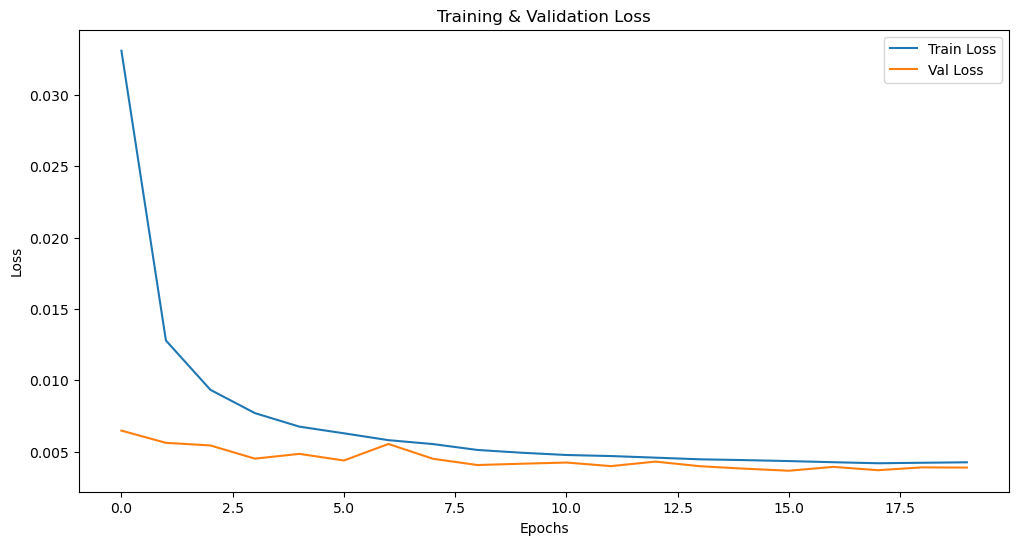

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

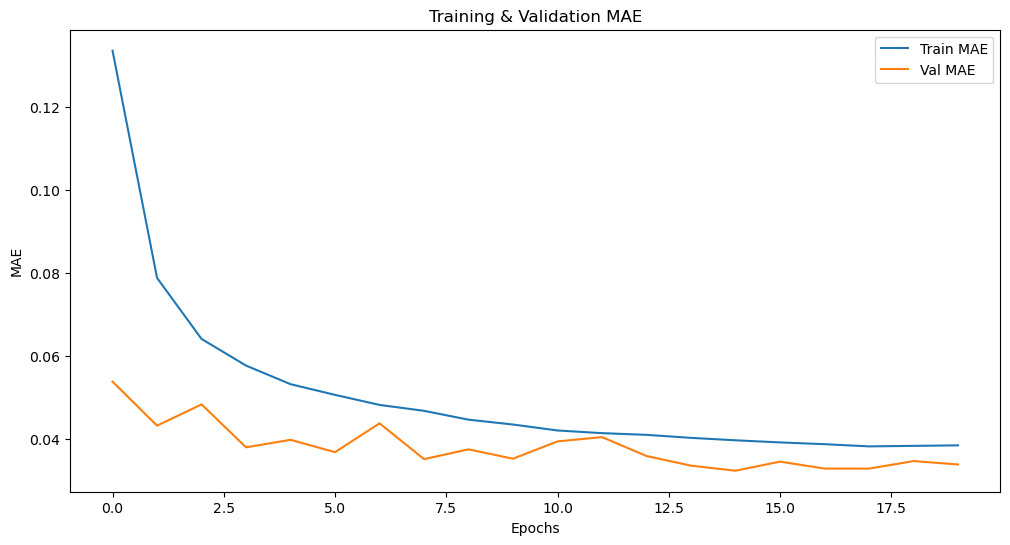

In [17]:
# Plot MAE if you want
plt.figure(figsize=(12,6))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training & Validation MAE')
plt.show()

In [18]:
model.eval()

Informer(
  (enc_embedding): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attn): ProbSparseAttention(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
        )
        (ff): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
        )
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )

In [19]:
all_preds = []
all_true = []
# Initialize device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        all_preds.append(outputs.cpu())
        all_true.append(y_batch.cpu())

# Concatenate all batches
y_pred_tensor = torch.cat(all_preds)
y_true_tensor = torch.cat(all_true)

In [20]:
preds, trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        if out.dim() == 2:
            out = out[:, -1]
        preds.append(out.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

print("Test MSE:", mean_squared_error(trues, preds))
print("Test MAE:", mean_absolute_error(trues, preds))
print("Test R2:", r2_score(trues, preds))

Test MSE: 0.0037316112
Test MAE: 0.033495344
Test R2: 0.9494576473909526


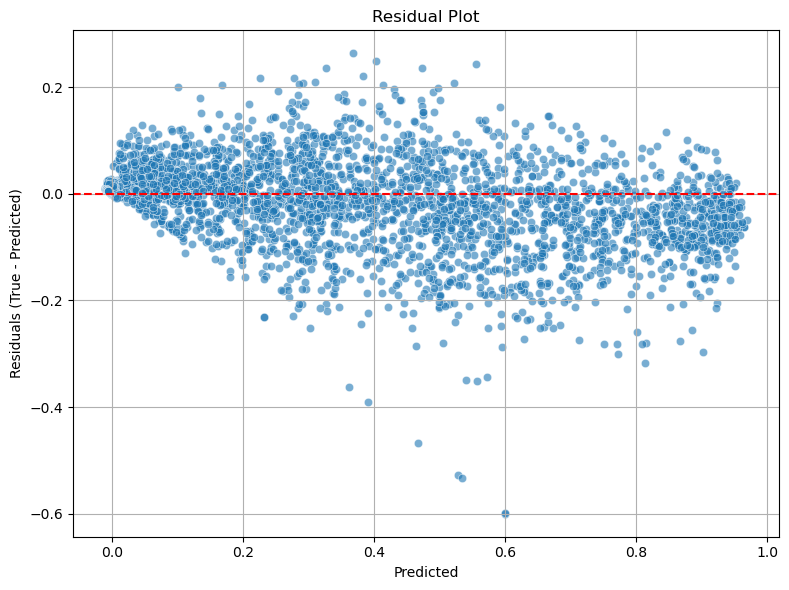

In [27]:
import seaborn as sns
# Residual Plot
residuals = trues - preds
plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals (True - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

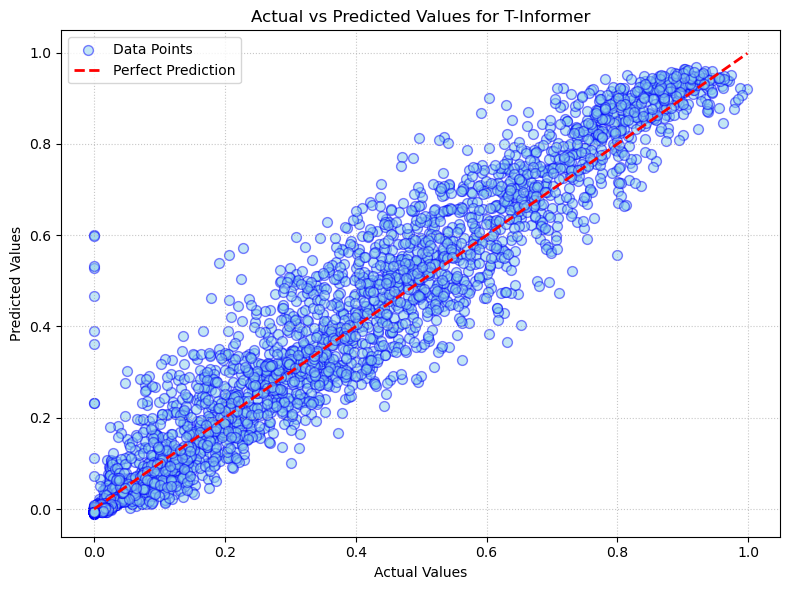

In [32]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(trues, preds,
            s=50,             # Slightly larger markers
            alpha=0.5,        # Good transparency to show density
            color='skyblue',  # A pleasant color for the points
            edgecolors='blue', # Darker edge for better definition
            label='Data Points')
plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--', linewidth=2, label='Perfect Prediction')  # identity line
plt.title('Actual vs Predicted Values for T-Informer')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
# Add a grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)
# Add a legend
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()